<img style="float: left; margin-right: 20px;" src="ocapy/ocapy_logo.jpeg">

# OCA.py - Visualizing the word confidence of OCR results (ALTO-XML)
by Michael Kubina

**OCA.py** is an acronym and describes this **O**CR **C**onfidence **A**nalysis script written in **py**thon.

This is a graduation work for the 2022 Data Librarian Certificate Course from the Technical University Cologne. The result of the graduation work is a script, which is called OCA.py. The script was published in August 2022. This is the corresponding jupyter-notebook with additional insights.

OCA.py is licensed under GPL3 (https://www.gnu.org/licenses/gpl-3.0.en.html)

## Preface

We will handle a lot of data and might be limited be the I/O data rate limit. So start the notebook with the following command, as suggested here: https://stackoverflow.com/questions/43490495/how-to-set-notebookapp-iopub-data-rate-limit-and-others-notebookapp-settings-in

`jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10`

## Defining document corpus

We need the METS file that holds a digital object together and has also some descriptive metadata. Furthermore we need all the ALTO files, that hold the OCR for each page. All the necessary files will be acquired through URLs, which follow a static pattern. We ignore any other files, that belong to the whole digital object, as we don't need those.

* `https://mets.sub.uni-hamburg.de/kitodo/PPN872169685_0021` (METS)
* `https://img.sub.uni-hamburg.de/kitodo/PPN872169685_0021/00000053.xml` (ALTO)

As we can see, the only thing we need is the record identifier.

In [1]:
# the test object(s)
#record_id = "PPN1026788544" # about 50 pages, good ocr, low confidence
record_id = "PPN86268370X" # about 150 pages, good ocr, high confidence
#record_id = "PPN1041860838" # about 350 pages, bad ocr -> wrong script, low confidence
#record_id = "PPN1672846668" # about 100 pages, bad ocr -> wrong script, extreme high confidences, visible anomaly

## Importing libraries

This project will download files through the internet through `requests`. We will save/load those and other files from the filesystem `os`. 

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import numpy as np
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap

## Function definitions

In [3]:
# download file, if it does not exist already
# (Source: https://techoverflow.net/2017/02/26/requests-download-file-if-it-doesnt-exist/)
# with small adjustments from myself
def download_file(filename, url):
    """
    Download an URL to a file
    """
    with open(filename, 'wb') as fout:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        # Write response data to file
        for block in response.iter_content(4096):
            fout.write(block)
            
def download_if_not_exists(filename, url):
    """
    Download a URL to a file if the file
    does not exist already.
    Returns
    -------
    True if the file was downloaded,
    False if it already existed
    """
    if not os.path.exists(filename):
        # create subfolders if necessary
        dirname = os.path.dirname(filename)
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        # give feedback if we are downloading something
        print("Retrieving: " + url, end="")
        download_file(filename, url)
        print(" -> Done!", end="\n")
        #return True
        return
    # give feedback if we are using a local copy
    print("Using local copy: " + filename)
    #return False

## Step 1 - File download

The file download happens in three steps...

### ... download the METS file

In [4]:
# path to METS directory
mets_dir = record_id + "/mets/" 

# download the METS/MODS
mets_url = "https://mets.sub.uni-hamburg.de/kitodo/" + str(record_id)
mets_filename = mets_dir + record_id + ".xml"
download_if_not_exists(mets_filename, mets_url)

Retrieving: https://mets.sub.uni-hamburg.de/kitodo/PPN86268370X -> Done!


### ... extract the fulltext URLs

The fulltext URLs are grouped in the `<mets:fileGrp USE="FULLTEXT"></mets:fileGrp>`

Each fulltext has file location `<mets:FLocat LOCTYPE="URL" xlink:href="https://img.sub.uni-hamburg.de/kitodo/PPN863173349_0006/00000001.xml"/>`

In [5]:
# read the METS file
mets=[]
with open(mets_filename, 'r', encoding='utf-8') as file:
    mets = file.read()

# cook a soup
mets_soup = BeautifulSoup(mets,"lxml-xml")

# get all file location elements
filegrp_fulltext = mets_soup.find('mets:fileGrp', { "USE" : "FULLTEXT" }).find_all('mets:FLocat')

# get all fulltext URLs from the xlink:href attribute
fulltext_path = []
for item in filegrp_fulltext:
    fulltext_path.append(item['xlink:href'])

### ... download the ALTO files

In [6]:
# download all ocr results
alto_dir = record_id + "/alto/"
for alto_url in fulltext_path:
    # download file
    alto_filename = alto_dir + os.path.basename(alto_url)
    download_if_not_exists(alto_filename, alto_url)

Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000001.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000002.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000003.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000004.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000005.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000006.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000007.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000008.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000009.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000010.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000011.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00

Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000097.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000098.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000099.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000100.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000101.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000102.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000103.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000104.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000105.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000106.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00000107.xml -> Done!
Retrieving: https://img.sub.uni-hamburg.de/kitodo/PPN86268370X/00

## Step 2 - Extract word confidencies

Now that we have all the necessary files, we will create a nested list that holds all word confidencies together. The structure is:
* a main list representing all pages of the document
* for each page a sublist representing all textlines within it
* for each textline a sublist representing all strings within it

In [7]:
# create main list
pages_wc = []

# loop through all ALTO files
for alto_url in fulltext_path:
    # read the ALTO file
    alto=[]
    alto_filename = alto_dir + os.path.basename(alto_url)
    with open(alto_filename, 'r', encoding='utf-8') as file:
        alto = file.read()
    
    # cook a soup
    alto_soup = BeautifulSoup(alto,"lxml-xml")
    
    # extract all textlines
    textlines = alto_soup.find_all('TextLine')
    
    # create sublist for textlines
    textlines_wc = []
    
    # loop through all textlines
    for item in textlines:
        # extract al strings
        strings = item.find_all('String')
        
        # create sublist for strings
        string_wc = []
        
        # loop through all strings
        for item in strings:
            # extract word confidencies for the strings
            string_wc.append(item['WC'])
        # add string to textline sublist
        textlines_wc.append(string_wc)
    
    # add textline to pages list
    pages_wc.append(textlines_wc)

### ... create a list of DataFrames for all pages

Each entry is a DataFrame for a single page, with the textlines as rows and the words as columns. We will format the axis accordingly and clean-up the DataFrames as well in order to process it later on. Otherwise mathematical operations would fail, as the entries would not be number types, but strings.

In [8]:
# create list of DataFrames
pages_df_list = [pd.DataFrame(item) for item in pages_wc]

# format and clean up each DataFrame
for index, item in enumerate(pages_df_list):
    # rename the axis
    pages_df_list[index].index = ['Textline {}'.format(i+1) for i in range(item.shape[0])]
    pages_df_list[index].columns = ['Word {}'.format(i+1) for i in range(item.shape[1])]
    
    # replace string "None" with NaN
    pages_df_list[index] = item.fillna(value=np.nan)
    # replace "1." with "1.0"
    pages_df_list[index] = item.replace("1.", "1.0")
    # transform all numbers (currently type=string) to real floating point numbers (type=float)
    pages_df_list[index] = item.astype(float)

### ...lets peek inside our main list of DataFrames
We now have a list of DataFrames, with an entry for each page. We will take a look at page 9, in order to see the internal structure. In certain cases, we might encounter empty pages and thus an empty output...

In [9]:
# a look at page 9 with five digits after the decimal point
# equals three digits after the decimal point for percentages
# remember: this is just a display property!
pd.set_option('display.precision',5)    
pages_df_list[8]

,Word 1,Word 2,Word 3,Word 4,Word 5
Textline 1,0.41167,0.57500,0.15833,0.41143,NaN
Textline 2,0.42500,0.24000,0.44125,NaN,NaN
Textline 3,0.39667,0.18333,0.39833,0.55500,NaN
Textline 4,0.62000,0.14000,0.22100,0.25571,NaN
Textline 5,0.19778,0.59500,0.45455,0.24000,0.30625
Textline 6,0.29500,0.61875,0.62000,0.51222,NaN
Textline 7,0.17000,0.20000,0.54600,0.55750,0.43857
Textline 8,0.43125,0.46833,0.25400,NaN,NaN
Textline 9,0.46000,0.41125,0.40500,0.44714,NaN
Textline 10,0.26667,0.48333,0.29545,NaN,NaN


## Step 3 - Statistics

### ...now lets create a separate DataFrame providing a general statistic
We also want to provide some general statistics for the pages, like the number of words, number of textlines, percentilles of word confidence, mean and standard deviation from the mean. So we really have just a basic description, but since the word confidencies are just artificial values with precise boundaries, where higher values not necessarily correlate with higher precision, we can very well use these. What we are interested in is how they relate to each other, which can be perfectly done here.

In [10]:
# extract how many textlines each page has
textlines = []
for item in pages_df_list:
    textlines.append(item.shape[0])

In [11]:
# a list holding all page statistics
pages_df_list_report = []

# format and clean up each DataFrame
for item in pages_df_list:
    # stack for single column
    stack = item.stack()
    # remove NaN
    stack.dropna()
    # describe the page and append to list
    pages_df_list_report.append(stack.describe())

# create a DataFrame out of the list
pages_df_list_report_df = pd.DataFrame(pages_df_list_report)
# change index names of axis
pages_df_list_report_df.index = ['Page {}'.format(i+1) for i in range(pages_df_list_report_df.shape[0])]
# add number of textlines as column
pages_df_list_report_df['textlines'] = textlines


### ...lets also peek into the page statistics

In [12]:
pages_df_list_report_df

,count,mean,std,min,25%,50%,75%,max,textlines
Page 1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
Page 2,1.0,0.60000,NaN,0.6,0.60,0.60,0.60,0.60,1
Page 3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
Page 4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
Page 5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
Page 163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
Page 164,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
Page 165,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
Page 166,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Step 4 - Visualize the results
This step is core of the whole process. With our DataFrames we have all necessary values to work with and to visualize them. If we look at our list of DataFrames and our general statistic, we can already see, that our values range between 0.0 and 1.0, so its very easy to think of a heatmap-alike visualization. Here we use the famous warming stripes visualization for climate data, that with its stripes is somehow similar to a books bound pages, when seen from the side. But furthermore, we want an in depth look at each page with all their textlines right down to each word.

So, what we want to try to achieve is:
* the general statistic will be a "warming strip" representanting a derived value (e.g. mean, median, etc) for each page.
* each page will be an image containing all its textlines stacked, with each textline being a separate "warming stripe"

### ... lets start easy with visualizing the general statistic
 The steps to create the warming stripes were found here: https://matplotlib.org/matplotblog/posts/warming-stripes/
 I derived the work, to suit the needs in this project, since we dont rely on previous climate data but an general threshold for each page.
 Also we will chose a different color model, to visualize high, medium or low word confidence.

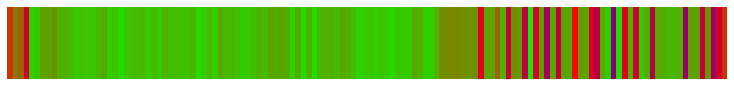

In [13]:
# create an image directory, if it does not exist already
images_dir = record_id + "/images/"
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

# create a directory for temporary files, if it does not exist already
temp_dir = record_id + "/temp/"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)


#last_item = pages_df_list[8].iloc[3].dropna().shape[0]

# how many pages have actually values to work with => skip empty pages
last_item = pages_df_list_report_df['mean'].dropna().shape[0]

# declare output figure as of fixed width and height
fig = plt.figure(figsize=(10, 1))

# dont print axeis
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()

# create a collection with a rectangle for each page
col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(0, last_item + 1)
])

# add mean page confidencies to collections array (column = vertical bar in plot)
col.set_array(pages_df_list_report_df['mean'].dropna())

# use linear colormap Blue-Red-Green (0.0, 0.5, 1.0)
col.set_cmap("brg")

# set limits, plot collection and save figure
col.set_clim(0.0,1.0)
ax.add_collection(col)
ax.set_ylim(0, 1)
ax.set_xlim(0, last_item +1)
fig.savefig(images_dir + record_id + '.png')

### ...now we need a function to concatenate multiple stripes into one single image
Since the above stripes (representing the mean confidence for each (written) page of the book) are not different, from how a single textline would appear, we need a function, that stacks all of those lines into one single image. Fortunately there was an example using `Pillow` for this task.

In this form we can only concatenate two images into one, which means, that for multiple textlines we would concatenate each new line to the compound image, that we priorly created.

In [14]:
#https://note.nkmk.me/en/python-pillow-concat-images/
from PIL import Image

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

### ...and can finally start plotting all "heatmaps"

In [15]:
# we need a library, which allows copying files, once the temporary warming stripes for each textline are concatenated and final
from shutil import copyfile

# now lets create the "heatmap" for each page in our list of DataFrames
for page_index, page in enumerate(pages_df_list):
    # of course with each textline as separate warming stripes
    for textline_index in range(0,(page.shape[0])):
        # print progress
        print("Page " + str(page_index) + " Line " + str(textline_index))

        # the next lines are basically the same as for the general statistic, thus no commentary
        # it would've been better to put this whole process into a separate function (DRY = don't repeat yourself)
        last_item = pages_df_list[page_index].iloc[textline_index].dropna().shape[0]

        fig = plt.figure(figsize=(10, 1))

        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_axis_off()

        col = PatchCollection([
            Rectangle((y, 0), 1, 1)
            for y in range(0, last_item + 1)
        ])

        col.set_array(pages_df_list[page_index].iloc[textline_index].dropna())
        col.set_cmap("brg")
        col.set_clim(0.0, 1.0)
        ax.add_collection(col)

        ax.set_ylim(0, 1)
        ax.set_xlim(0, last_item +1)
        
        
        # if it's the first textline, simply store it
        if textline_index == 0:
            fig.savefig(temp_dir + str(page_index) + '.png')
        # now with every additional textline concatenate the images (the new image with the last concatenated image or the very first image respectively) )
        if textline_index > 0:
            fig.savefig(temp_dir + 'concat.png')
            base = Image.open(temp_dir + str(page_index) + '.png')
            add = Image.open(temp_dir + 'concat.png')
            get_concat_v(base, add).save(temp_dir + str(page_index) + '.png', 'PNG')
        # close the plot to free memory
        plt.close()
        
    # now move the files from the temp folder to the images folder, since the temp folder is a temporary working directory
    if not os.path.exists(temp_dir + str(page_index) + '.png'):
        # overwrite condition
        if os.path.isfile(images_dir + str(page_index) + '.png'):
            os.remove(images_dir + str(page_index) + '.png')
        # fallback for empty pages -> copy blank page representative
        copyfile('ocapy/blank.png', images_dir + str(page_index) + '.png')
    else:
        # overwrite condition
        if os.path.isfile(images_dir + str(page_index) + '.png'):
            os.remove(images_dir + str(page_index) + '.png')
        # rename actually moves the file from temp to images
        os.rename(temp_dir + str(page_index) + '.png', images_dir + str(page_index) + '.png')
    

Page 1 Line 0
Page 5 Line 0
Page 5 Line 1
Page 6 Line 0
Page 6 Line 1
Page 6 Line 2
Page 6 Line 3
Page 6 Line 4
Page 6 Line 5
Page 6 Line 6
Page 8 Line 0
Page 8 Line 1
Page 8 Line 2
Page 8 Line 3
Page 8 Line 4
Page 8 Line 5
Page 8 Line 6
Page 8 Line 7
Page 8 Line 8
Page 8 Line 9
Page 8 Line 10
Page 10 Line 0
Page 10 Line 1
Page 10 Line 2
Page 10 Line 3
Page 10 Line 4
Page 10 Line 5
Page 10 Line 6
Page 10 Line 7
Page 10 Line 8
Page 10 Line 9
Page 10 Line 10
Page 10 Line 11
Page 10 Line 12
Page 10 Line 13
Page 10 Line 14
Page 10 Line 15
Page 10 Line 16
Page 10 Line 17
Page 10 Line 18
Page 10 Line 19
Page 10 Line 20
Page 10 Line 21
Page 10 Line 22
Page 10 Line 23
Page 10 Line 24
Page 10 Line 25
Page 10 Line 26
Page 10 Line 27
Page 10 Line 28
Page 10 Line 29
Page 10 Line 30
Page 10 Line 31
Page 10 Line 32
Page 10 Line 33
Page 10 Line 34
Page 10 Line 35
Page 12 Line 0
Page 12 Line 1
Page 12 Line 2
Page 12 Line 3
Page 12 Line 4
Page 12 Line 5
Page 12 Line 6
Page 12 Line 7
Page 12 Line 8
Page

Page 24 Line 17
Page 24 Line 18
Page 24 Line 19
Page 24 Line 20
Page 24 Line 21
Page 24 Line 22
Page 24 Line 23
Page 24 Line 24
Page 24 Line 25
Page 24 Line 26
Page 24 Line 27
Page 24 Line 28
Page 24 Line 29
Page 24 Line 30
Page 24 Line 31
Page 24 Line 32
Page 24 Line 33
Page 24 Line 34
Page 24 Line 35
Page 24 Line 36
Page 24 Line 37
Page 24 Line 38
Page 24 Line 39
Page 24 Line 40
Page 24 Line 41
Page 24 Line 42
Page 24 Line 43
Page 24 Line 44
Page 24 Line 45
Page 24 Line 46
Page 24 Line 47
Page 24 Line 48
Page 24 Line 49
Page 24 Line 50
Page 25 Line 0
Page 25 Line 1
Page 25 Line 2
Page 25 Line 3
Page 25 Line 4
Page 25 Line 5
Page 25 Line 6
Page 25 Line 7
Page 25 Line 8
Page 25 Line 9
Page 25 Line 10
Page 25 Line 11
Page 25 Line 12
Page 25 Line 13
Page 25 Line 14
Page 25 Line 15
Page 25 Line 16
Page 25 Line 17
Page 25 Line 18
Page 25 Line 19
Page 25 Line 20
Page 25 Line 21
Page 25 Line 22
Page 25 Line 23
Page 25 Line 24
Page 25 Line 25
Page 25 Line 26
Page 25 Line 27
Page 25 Line 28
Pa

Page 35 Line 37
Page 35 Line 38
Page 35 Line 39
Page 35 Line 40
Page 35 Line 41
Page 35 Line 42
Page 35 Line 43
Page 35 Line 44
Page 35 Line 45
Page 35 Line 46
Page 35 Line 47
Page 35 Line 48
Page 35 Line 49
Page 35 Line 50
Page 35 Line 51
Page 35 Line 52
Page 35 Line 53
Page 35 Line 54
Page 36 Line 0
Page 36 Line 1
Page 36 Line 2
Page 36 Line 3
Page 36 Line 4
Page 36 Line 5
Page 36 Line 6
Page 36 Line 7
Page 36 Line 8
Page 36 Line 9
Page 36 Line 10
Page 36 Line 11
Page 36 Line 12
Page 36 Line 13
Page 36 Line 14
Page 36 Line 15
Page 36 Line 16
Page 36 Line 17
Page 36 Line 18
Page 36 Line 19
Page 36 Line 20
Page 36 Line 21
Page 36 Line 22
Page 36 Line 23
Page 36 Line 24
Page 36 Line 25
Page 36 Line 26
Page 36 Line 27
Page 36 Line 28
Page 36 Line 29
Page 36 Line 30
Page 36 Line 31
Page 36 Line 32
Page 36 Line 33
Page 36 Line 34
Page 36 Line 35
Page 36 Line 36
Page 36 Line 37
Page 36 Line 38
Page 36 Line 39
Page 36 Line 40
Page 36 Line 41
Page 36 Line 42
Page 36 Line 43
Page 36 Line 44
Pa

Page 45 Line 47
Page 45 Line 48
Page 45 Line 49
Page 45 Line 50
Page 45 Line 51
Page 46 Line 0
Page 46 Line 1
Page 46 Line 2
Page 46 Line 3
Page 46 Line 4
Page 46 Line 5
Page 46 Line 6
Page 46 Line 7
Page 46 Line 8
Page 46 Line 9
Page 46 Line 10
Page 46 Line 11
Page 46 Line 12
Page 46 Line 13
Page 46 Line 14
Page 46 Line 15
Page 46 Line 16
Page 46 Line 17
Page 46 Line 18
Page 46 Line 19
Page 46 Line 20
Page 46 Line 21
Page 46 Line 22
Page 46 Line 23
Page 46 Line 24
Page 46 Line 25
Page 46 Line 26
Page 46 Line 27
Page 46 Line 28
Page 46 Line 29
Page 46 Line 30
Page 46 Line 31
Page 46 Line 32
Page 46 Line 33
Page 46 Line 34
Page 46 Line 35
Page 46 Line 36
Page 46 Line 37
Page 46 Line 38
Page 46 Line 39
Page 46 Line 40
Page 46 Line 41
Page 46 Line 42
Page 46 Line 43
Page 46 Line 44
Page 46 Line 45
Page 46 Line 46
Page 46 Line 47
Page 46 Line 48
Page 46 Line 49
Page 46 Line 50
Page 46 Line 51
Page 47 Line 0
Page 47 Line 1
Page 47 Line 2
Page 47 Line 3
Page 47 Line 4
Page 47 Line 5
Page 47 

Page 56 Line 9
Page 56 Line 10
Page 56 Line 11
Page 56 Line 12
Page 56 Line 13
Page 56 Line 14
Page 56 Line 15
Page 56 Line 16
Page 56 Line 17
Page 56 Line 18
Page 56 Line 19
Page 56 Line 20
Page 56 Line 21
Page 56 Line 22
Page 56 Line 23
Page 56 Line 24
Page 56 Line 25
Page 56 Line 26
Page 56 Line 27
Page 56 Line 28
Page 57 Line 0
Page 57 Line 1
Page 57 Line 2
Page 57 Line 3
Page 57 Line 4
Page 57 Line 5
Page 57 Line 6
Page 57 Line 7
Page 57 Line 8
Page 57 Line 9
Page 57 Line 10
Page 57 Line 11
Page 57 Line 12
Page 57 Line 13
Page 57 Line 14
Page 57 Line 15
Page 57 Line 16
Page 57 Line 17
Page 57 Line 18
Page 57 Line 19
Page 57 Line 20
Page 57 Line 21
Page 57 Line 22
Page 57 Line 23
Page 57 Line 24
Page 57 Line 25
Page 57 Line 26
Page 57 Line 27
Page 57 Line 28
Page 57 Line 29
Page 57 Line 30
Page 57 Line 31
Page 57 Line 32
Page 57 Line 33
Page 57 Line 34
Page 57 Line 35
Page 57 Line 36
Page 57 Line 37
Page 57 Line 38
Page 57 Line 39
Page 57 Line 40
Page 57 Line 41
Page 57 Line 42
Pag

Page 67 Line 40
Page 67 Line 41
Page 68 Line 0
Page 68 Line 1
Page 68 Line 2
Page 68 Line 3
Page 68 Line 4
Page 68 Line 5
Page 68 Line 6
Page 68 Line 7
Page 68 Line 8
Page 68 Line 9
Page 68 Line 10
Page 68 Line 11
Page 68 Line 12
Page 68 Line 13
Page 68 Line 14
Page 68 Line 15
Page 68 Line 16
Page 68 Line 17
Page 68 Line 18
Page 68 Line 19
Page 68 Line 20
Page 68 Line 21
Page 68 Line 22
Page 68 Line 23
Page 68 Line 24
Page 68 Line 25
Page 68 Line 26
Page 68 Line 27
Page 68 Line 28
Page 68 Line 29
Page 68 Line 30
Page 68 Line 31
Page 68 Line 32
Page 68 Line 33
Page 68 Line 34
Page 68 Line 35
Page 68 Line 36
Page 68 Line 37
Page 68 Line 38
Page 68 Line 39
Page 68 Line 40
Page 68 Line 41
Page 68 Line 42
Page 68 Line 43
Page 68 Line 44
Page 68 Line 45
Page 68 Line 46
Page 68 Line 47
Page 68 Line 48
Page 68 Line 49
Page 68 Line 50
Page 68 Line 51
Page 68 Line 52
Page 69 Line 0
Page 69 Line 1
Page 69 Line 2
Page 69 Line 3
Page 69 Line 4
Page 69 Line 5
Page 69 Line 6
Page 69 Line 7
Page 69 Li

Page 78 Line 5
Page 78 Line 6
Page 78 Line 7
Page 78 Line 8
Page 78 Line 9
Page 78 Line 10
Page 78 Line 11
Page 78 Line 12
Page 78 Line 13
Page 78 Line 14
Page 78 Line 15
Page 78 Line 16
Page 78 Line 17
Page 78 Line 18
Page 78 Line 19
Page 78 Line 20
Page 78 Line 21
Page 78 Line 22
Page 78 Line 23
Page 78 Line 24
Page 78 Line 25
Page 78 Line 26
Page 78 Line 27
Page 78 Line 28
Page 78 Line 29
Page 78 Line 30
Page 78 Line 31
Page 78 Line 32
Page 78 Line 33
Page 78 Line 34
Page 78 Line 35
Page 78 Line 36
Page 78 Line 37
Page 78 Line 38
Page 78 Line 39
Page 78 Line 40
Page 78 Line 41
Page 78 Line 42
Page 78 Line 43
Page 78 Line 44
Page 78 Line 45
Page 78 Line 46
Page 78 Line 47
Page 78 Line 48
Page 78 Line 49
Page 78 Line 50
Page 78 Line 51
Page 79 Line 0
Page 79 Line 1
Page 79 Line 2
Page 79 Line 3
Page 79 Line 4
Page 79 Line 5
Page 79 Line 6
Page 79 Line 7
Page 79 Line 8
Page 79 Line 9
Page 79 Line 10
Page 79 Line 11
Page 79 Line 12
Page 79 Line 13
Page 79 Line 14
Page 79 Line 15
Page 79

Page 87 Line 114
Page 87 Line 115
Page 87 Line 116
Page 87 Line 117
Page 87 Line 118
Page 88 Line 0
Page 88 Line 1
Page 88 Line 2
Page 88 Line 3
Page 88 Line 4
Page 88 Line 5
Page 88 Line 6
Page 88 Line 7
Page 88 Line 8
Page 88 Line 9
Page 88 Line 10
Page 88 Line 11
Page 88 Line 12
Page 88 Line 13
Page 88 Line 14
Page 88 Line 15
Page 88 Line 16
Page 88 Line 17
Page 88 Line 18
Page 88 Line 19
Page 88 Line 20
Page 88 Line 21
Page 88 Line 22
Page 88 Line 23
Page 88 Line 24
Page 88 Line 25
Page 88 Line 26
Page 88 Line 27
Page 88 Line 28
Page 88 Line 29
Page 88 Line 30
Page 88 Line 31
Page 88 Line 32
Page 88 Line 33
Page 88 Line 34
Page 88 Line 35
Page 88 Line 36
Page 88 Line 37
Page 88 Line 38
Page 88 Line 39
Page 88 Line 40
Page 88 Line 41
Page 88 Line 42
Page 88 Line 43
Page 88 Line 44
Page 88 Line 45
Page 88 Line 46
Page 88 Line 47
Page 88 Line 48
Page 88 Line 49
Page 88 Line 50
Page 88 Line 51
Page 88 Line 52
Page 88 Line 53
Page 88 Line 54
Page 88 Line 55
Page 88 Line 56
Page 88 Line 

Page 91 Line 37
Page 91 Line 38
Page 91 Line 39
Page 91 Line 40
Page 91 Line 41
Page 91 Line 42
Page 91 Line 43
Page 91 Line 44
Page 91 Line 45
Page 91 Line 46
Page 91 Line 47
Page 91 Line 48
Page 91 Line 49
Page 91 Line 50
Page 91 Line 51
Page 91 Line 52
Page 91 Line 53
Page 91 Line 54
Page 91 Line 55
Page 91 Line 56
Page 91 Line 57
Page 91 Line 58
Page 91 Line 59
Page 91 Line 60
Page 91 Line 61
Page 91 Line 62
Page 91 Line 63
Page 91 Line 64
Page 91 Line 65
Page 91 Line 66
Page 91 Line 67
Page 91 Line 68
Page 91 Line 69
Page 91 Line 70
Page 91 Line 71
Page 91 Line 72
Page 91 Line 73
Page 91 Line 74
Page 91 Line 75
Page 91 Line 76
Page 91 Line 77
Page 91 Line 78
Page 91 Line 79
Page 91 Line 80
Page 91 Line 81
Page 91 Line 82
Page 91 Line 83
Page 91 Line 84
Page 91 Line 85
Page 91 Line 86
Page 91 Line 87
Page 91 Line 88
Page 91 Line 89
Page 91 Line 90
Page 91 Line 91
Page 91 Line 92
Page 91 Line 93
Page 91 Line 94
Page 91 Line 95
Page 91 Line 96
Page 91 Line 97
Page 91 Line 98
Page 91 

Page 112 Line 6
Page 113 Line 0
Page 113 Line 1
Page 114 Line 0
Page 114 Line 1
Page 114 Line 2
Page 114 Line 3
Page 114 Line 4
Page 114 Line 5
Page 114 Line 6
Page 115 Line 0
Page 115 Line 1
Page 116 Line 0
Page 118 Line 0
Page 118 Line 1
Page 118 Line 2
Page 119 Line 0
Page 120 Line 0
Page 120 Line 1
Page 120 Line 2
Page 120 Line 3
Page 120 Line 4
Page 120 Line 5
Page 122 Line 0
Page 122 Line 1
Page 122 Line 2
Page 122 Line 3
Page 122 Line 4
Page 125 Line 0
Page 125 Line 1
Page 127 Line 0
Page 127 Line 1
Page 128 Line 0
Page 128 Line 1
Page 128 Line 2
Page 128 Line 3
Page 128 Line 4
Page 128 Line 5
Page 132 Line 0
Page 132 Line 1
Page 133 Line 0
Page 133 Line 1
Page 134 Line 0
Page 135 Line 0
Page 135 Line 1
Page 136 Line 0
Page 136 Line 1
Page 136 Line 2
Page 137 Line 0
Page 137 Line 1
Page 138 Line 0
Page 138 Line 1
Page 140 Line 0
Page 140 Line 1
Page 140 Line 2
Page 141 Line 0
Page 141 Line 1
Page 142 Line 0
Page 142 Line 1
Page 142 Line 2
Page 142 Line 3
Page 142 Line 4
Page 142

### ...now resize all images to an equal width and height
There will be pages with few and with very much textlines. For a cleaner look, we will resize all output images to a DIN A7 format at screen resolution, with exception of the general statistic, which will be in DIN A5.

In [16]:
for filename in os.listdir(images_dir):
    # open the file
    with Image.open(images_dir + filename) as img:
        # resize it to the following width and height
        (width, height) = (210, 298) # DIN A7 at screen resolution (72dpi)
        img.resize((width, height), resample=Image.BOX).save(images_dir + filename)

# do it again for the general statistic
with Image.open(images_dir + record_id + '.png') as img:
        (width, height) = (420, 595) # DIN A5 at screen resolution (72dpi)
        img.resize((width, height), resample=Image.BOX).save(images_dir + record_id + '.png')

### ...we might want to know the confidence distribution as well

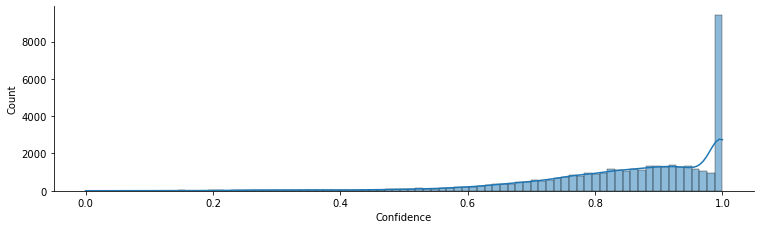

In [17]:
# simply stack all word confidencies into one single column and clean up
confidence_df = pd.concat(pages_df_list, axis=0).stack()
confidence_df = confidence_df.reset_index(name='Confidence')
confidence_df.drop('level_0', axis=1, inplace=True)
confidence_df.drop('level_1', axis=1, inplace=True)
confidence_df

# and print and save a distribution plot
import seaborn as sns

#sns.set_theme(style="whitegrid")
g = sns.displot(
    confidence_df, x="Confidence", kde=True
)
g.figure.set_figwidth(12)
g.figure.set_figheight(3) 
g.figure.savefig(images_dir + record_id + '_displot.png')

## Step 5 - Generate Report
Now its finally time to put all the pieces together and to create a report. We will output a HTML file, which will inherit our images and statistics, but also some descriptive metadata. We will use `Bootstrap`, because it provides us with some neat looking CSS classes, a grid-system and a responsive web-design.

Be advised, that its merely a proof of concept and the we are not extracting nearly as much metadata as we could and that we only use a limited set of features, that `Bootstrap` offers.

In [18]:
# extract some metadata
mods_title = mets_soup.find('mods:title').string if mets_soup.find('mods:title') else "Undefined Title"
mods_author = mets_soup.find('mods:displayForm').string if mets_soup.find('mods:displayForm') else "Undefined Author"
mods_year = mets_soup.find('mods:dateIssued').string if mets_soup.find('mods:dateIssued') else "Undefined Year"

# filename for the report-file
report_filename = record_id + "/" + record_id + "_report.html"

# header and opening the HTML body
report_start = '<!doctype html><html lang="en><head><meta charset="utf-8">\
                <meta name="viewport" content="width=device-width, initial-scale=1">\
                <title>OCA.py Report - ' + record_id + '</title>\
                <link href="../ocapy/bootstrap.min.css" rel="stylesheet"></head>\
                <body><script src="../ocapy/bootstrap.bundle.min.js"></script>'

# closing the HTML body
report_end = '</body></html>'

# the overview shows the contents of the general statistic and some descriptive metadata
report_overview = '\
<div class="container">\
<h1><a href="https://resolver.sub.uni-hamburg.de/kitodo/' + record_id + '" class="link-dark">Result for ' + record_id + '</a></h1>\
</div>\
<div class="container">\
<div class="row gx-2 m-1">\
<div class="col-lg-12 col-md-12 h-100">\
<div class="card mb-3">\
  <div class="row g-0">\
    <div class="col-md-4">\
      <a href="https://mets.sub.uni-hamburg.de/kitodo/' + record_id + '"><img src="images/' + record_id + '.png" class="img-fluid rounded-start" alt="..."></a>\
    </div>\
    <div class="col-md-8">\
      <div class="card-body">\
        <h5 class="card-title">' + mods_author + ' (' + mods_year + '): <em>' + mods_title + '</em></h5><br>\
        <h6 class="card-subtitle mb-2 text-muted">Page Stats</h6>\
    <p class="font-monospace">\
    Total Pages: ' + str(int(pages_df_list_report_df.shape[0])) + '<br>\
    Total Words: ' + str(int(pages_df_list_report_df['count'].sum())) + '<br>\
    Total Lines: ' + str(int(pages_df_list_report_df['textlines'].sum())) + '<br>\
    </p>\
    <h6 class="card-subtitle mb-2 text-muted">Word Confidence</h6>\
    <p class="font-monospace">\
    &#8709;&nbsp;mean:&nbsp;' + str(pages_df_list_report_df['mean'].mean())[0:4] + '<br>\
    &#8709;&nbsp;std:&nbsp;&nbsp;' + str(pages_df_list_report_df['std'].mean())[0:4] + '<br>\
    <br>\
    &#8709;&nbsp;25%:&nbsp;&nbsp;' + str(pages_df_list_report_df['25%'].mean())[0:4] + '<br>\
    &#8709;&nbsp;50%:&nbsp;&nbsp;' + str(pages_df_list_report_df['50%'].mean())[0:4] + '<br>\
    &#8709;&nbsp;75%:&nbsp;&nbsp;' + str(pages_df_list_report_df['75%'].mean())[0:4] + '<br>\
    </p>\
        <img src="images/' + record_id + '_displot.png" class="img-fluid" alt="...">\
      </div>\
    </div>\
  </div>\
</div>\
</div>\
</div>\
</div>\
'

# add container before first iteration
report_details = '<div class="container">'

# now fill it, but make sure, that each row has only 6 columns
# Bootstrap has a gridsystem consisting of up to 12 columns each row, we go with 6
for counter in range(len(fulltext_path)):

    # close row after each 6 cards
    if counter % 6 == 0 and counter != 0:
        report_details += '</div>'
    # add new row each 6 cards
    if counter % 6 == 0:
        report_details += '<div class="row gx-2 m-1"></div><div class="row gx-2 m-1">'
    
    # add card to row
    # each card is a detailed statistic for each page with the heatmap of each page
    report_details += '\
    <div class="col-lg-2 col-md-12 h-100">\
    <div class="card border-dark">\
    <a href="alto/' + str(counter + 1).zfill(8) + '.xml"><img src="images/' + str(counter) + '.png" class="card-img-top" alt="Page ' + str(counter + 1) + '"></a>\
    <div class="card-body">\
    <h5 class="card-title"><a href="https://pic.sub.uni-hamburg.de/kitodo/' + record_id + '/' + str(counter + 1).zfill(8) + '.tif" class="link-dark">Page ' + str(counter + 1) + '</a></h5>\
    <h6 class="card-subtitle mb-2 text-muted">Page Stats</h6>\
    <p class="font-monospace">\
    Words: ' + str(int(pages_df_list_report_df['count'].iloc[counter])) + '<br>\
    Lines: ' + str(len(pages_df_list[counter])) + '<br>\
    </p>\
    <h6 class="card-subtitle mb-2 text-muted">Word Confidence</h6>\
    <p class="font-monospace">\
    mean:&nbsp;' + str(pages_df_list_report_df['mean'].iloc[counter])[0:4] + '<br>\
    std:&nbsp;&nbsp;' + str(pages_df_list_report_df['std'].iloc[counter])[0:4] + '<br>\
    <br>\
    <!--min:&nbsp;&nbsp;' + str(pages_df_list_report_df['min'].iloc[counter])[0:4] + '<br>-->\
    25%:&nbsp;&nbsp;' + str(pages_df_list_report_df['25%'].iloc[counter])[0:4] + '<br>\
    50%:&nbsp;&nbsp;' + str(pages_df_list_report_df['50%'].iloc[counter])[0:4] + '<br>\
    75%:&nbsp;&nbsp;' + str(pages_df_list_report_df['75%'].iloc[counter])[0:4] + '<br>\
    <!--max:&nbsp;&nbsp;' + str(pages_df_list_report_df['max'].iloc[counter])[0:4] + '-->\
    </p>\
    </div>\
    </div>\
    </div>'
    
# close container if end of document
report_details += '</div>'

# now put all report-pieces together
report = report_start + report_overview + report_details + report_end

# cook a soup (we need an XML object from the string provided)
report_soup = BeautifulSoup(report)
# prettify the HTML, so it won't look nasty
report_pretty = str(report_soup.prettify()).encode(encoding='UTF-8')

# finally save our report
with open(report_filename, 'wb') as report_file:
    report_file.write(report_pretty)

# Done

I might note, that this script is functioning very narrowly in a specific usecase, where it matches a certain interpretation of the METS/MODS schema. Also it can't be called with parameters, so it's not possible to use it conveniently through the command shell and to automate all this analysis - at least not in the scope of this graduation work. And of course, this script won't work on ALTO-XML without the WC-Attribute within the String-Element.

Feel free to adjust it to your needs or take a look at https://github.com/michaelkubina/ocapy if there have been any future updates. You will find this original graduation work unaltered in the "graduation_work"-branch with all corresponding documents.